# Convert the binary and categorical feature space
- Fuse categoricies for each feature into smaller number of categories based on conditional probabilities
- Calculate how much edge each category value has over the bulk frequency of class1
- Replace the category value with those ratios to inflate the differeces in conditional probabilities

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

from importlib import reload
from matplotlib import cm
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import (make_scorer, roc_auc_score, 
                             classification_report, 
                             precision_recall_curve,
                             roc_curve)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from feature_processing import (create_contingency_table,
                                calculate_conditional_prob_bin,
                                encode_my_categorical_labels,
                                calculate_conditional_prob_cat,
                                estimate_cond_prob_density,
                                bin_myFeature)
import feature_analysis as fa
import porto_seguro as ps

/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def my_gini(y_true, y_probas):
    auc = roc_auc_score(y_true, y_probas[:, 1])
    gini = 2*auc - 1
    return gini

gini_scorer = make_scorer(my_gini, needs_proba=True, greater_is_better=True)

In [3]:
train = pd.read_csv('train.csv', header=0)

all_fs = train.columns[:-1]
binary_fs = sorted([f for f in all_fs if '_bin' in f])
categorical_fs = sorted([f for f in all_fs if '_cat' in f])
other_fs = sorted([f for f in all_fs
            if f not in binary_fs
            if f not in categorical_fs])

binaries = train[binary_fs]
categoricals = train[categorical_fs]
others = train[other_fs[1:-1]]

new_categoricals = ps.fuseCategoricalFeatures(categoricals)

bincats = pd.concat([binaries, new_categoricals], axis=1)
target = train.target

In [4]:
reload(ps)

<module 'porto_seguro' from '/home/ryohayama/python_current/porto_seguro/porto_seguro.py'>

In [5]:
bincat2probas = {}
for i, f in enumerate(bincats.columns):
    fvt = fa.FeatureVsTarget(bincats[f], target)
    bincat2probas[f] = (100*(fvt.calculate_deviation(mode='ratio')[0] - 1)[1]).to_dict()

In [6]:
bincat2probas['ps_car_03_cat']

{0: -10.263633402873607, 1: 8.478205372761982, 2: 32.513247918634434}

In [7]:
bincat_converted = pd.DataFrame()
for i, f in enumerate(bincats.columns):
    bincat_converted[f] = bincats[f].replace(bincat2probas[f])

In [8]:
bincat_converted.head(5)

,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat
0,0.094183,0.246950,-0.078457,-0.180291,0.656528,14.095330,29.912302,-2.993119,2.019795,-0.018024,...,10.54458,-8.751671,-4.612259,23.282374,-3.261944,0.043887,8.665033,4.171961,6.025876,-7.085708
1,0.094183,0.246950,-0.078457,-0.180291,-1.224514,14.095330,-10.348293,15.266355,2.019795,-0.018024,...,-13.00161,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,-27.910814,-1.983385,-4.546991,-7.085708
2,0.094183,0.246950,-0.078457,-0.180291,-1.224514,14.095330,-10.348293,15.266355,2.019795,-0.018024,...,-13.00161,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,-11.434986,11.888150,6.025876,-7.085708
3,0.094183,-0.416609,0.097528,-0.180291,0.656528,-21.703055,-10.348293,-2.993119,2.019795,-0.018024,...,10.54458,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,24.500160,-1.983385,-4.546991,-7.085708
4,0.094183,-0.416609,0.097528,0.447503,-1.224514,-21.703055,-10.348293,-2.993119,2.019795,-0.018024,...,-13.00161,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,-27.910814,4.171961,6.025876,-7.085708


## Take a look at continuous/ordinal features

In [9]:
others.shape

(595212, 26)

In [11]:
for i, f in enumerate(others.columns):
    data = others[f]
    print('%s: %d unique vals - ' % (f, len(data.unique())), data.unique())

ps_calc_01: 10 unique vals -  [ 0.6  0.3  0.5  0.4  0.7  0.2  0.1  0.9  0.8  0. ]
ps_calc_02: 10 unique vals -  [ 0.5  0.1  0.7  0.9  0.6  0.8  0.4  0.   0.3  0.2]
ps_calc_03: 10 unique vals -  [ 0.2  0.3  0.1  0.   0.4  0.5  0.6  0.8  0.9  0.7]
ps_calc_04: 6 unique vals -  [3 2 1 4 0 5]
ps_calc_05: 7 unique vals -  [1 2 4 3 0 5 6]
ps_calc_06: 11 unique vals -  [10  9  7  6  8  5  4  3  2  1  0]
ps_calc_07: 10 unique vals -  [1 5 3 2 4 6 0 7 8 9]
ps_calc_08: 11 unique vals -  [10  8 11  6  9  7  5 12  4  3  2]
ps_calc_09: 8 unique vals -  [1 2 4 3 0 5 6 7]
ps_calc_10: 26 unique vals -  [ 5  7  2 12  8 10 13 11  9 18  4 15  6 14 16  3  1 17  0 21 19 20 22 23 25
 24]
ps_calc_11: 20 unique vals -  [ 9  3  4  2  7  6  5 10  8  1  0 13 11 12 14 15 16 19 17 18]
ps_calc_12: 11 unique vals -  [ 1  2  0  5  3  4  6  7  8  9 10]
ps_calc_13: 14 unique vals -  [ 5  1  7  4  0  3  6  2  8 10  9 11 12 13]
ps_calc_14: 24 unique vals -  [ 8  9  7  3 10  6  5 11  4 14 13 12 16  2  1 15 17  0 19 20 18 2

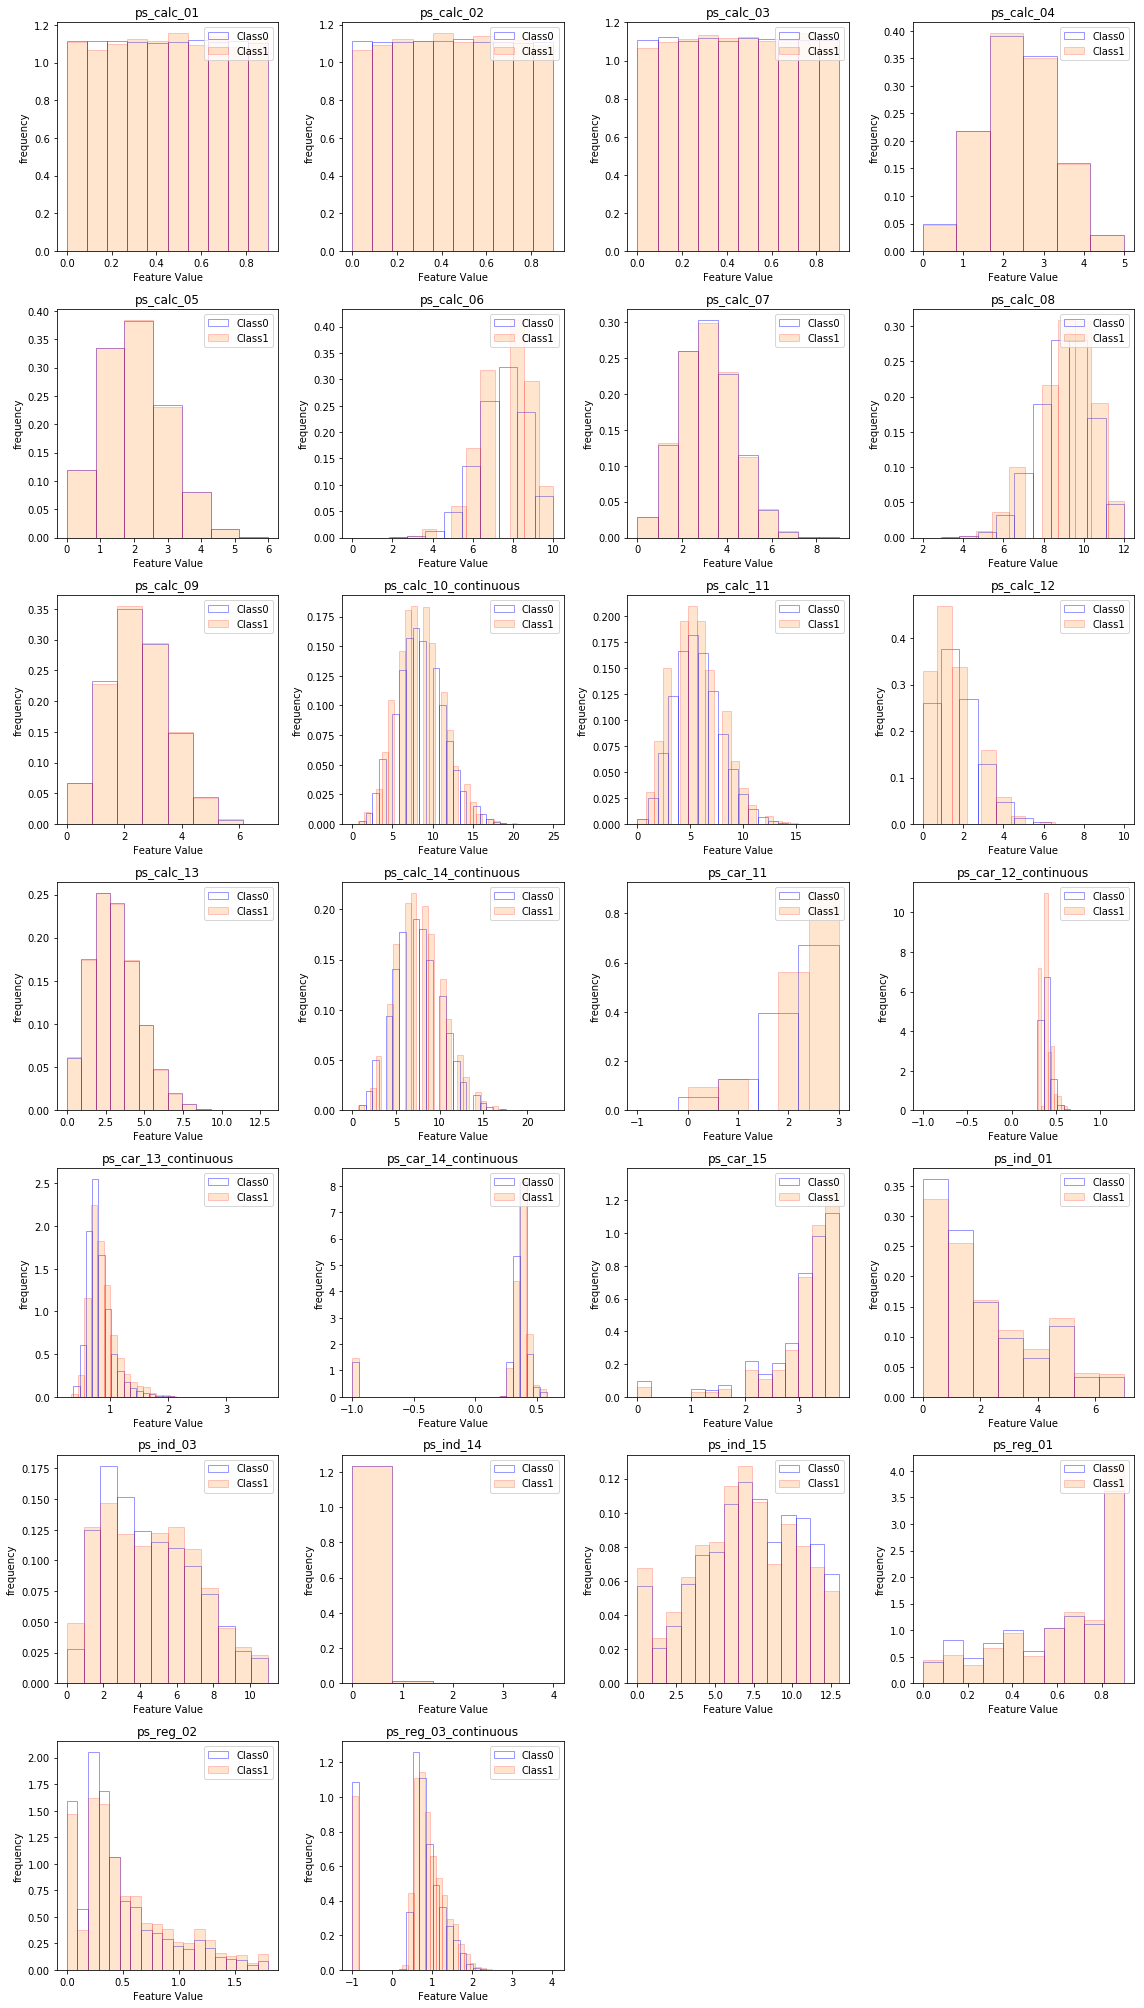

In [27]:
others2 = others.copy()
fig = plt.figure(figsize=(16, 28))
for i, f in enumerate(others2.columns):
    ax = fig.add_subplot(7, 4, i+1)
    data = others2[f]
    class0s = data[target == 0]
    class1s = data[target == 1]
    if len(data.unique()) > 20:
        bins = 30
        f = f + '_continuous'
    else:
        bins = len(data.unique())
    ax.hist(class0s, bins=bins, normed=True, edgecolor='b', alpha=0.4, fill=False, label='Class0')
    ax.hist(class1s, bins=bins, normed=True, edgecolor='r', alpha=0.2, fill=True, label='Class1')
    ax.set_title('%s' % f)
    ax.set_xlabel('Feature Value')
    ax.set_ylabel('frequency')
    ax.legend(loc='upper right')

plt.tight_layout()

## Digitized them before conditional probability analysis

In [13]:
others.loc[:, 'ps_car_12'] = bin_myFeature(others.loc[:, 'ps_car_12'], 0, 1.5, bins=20)[1]
others.loc[:, 'ps_car_13'] = bin_myFeature(others.loc[:, 'ps_car_13'], 0, 4, bins=50)[1]
others.loc[:, 'ps_car_13'] = bin_myFeature(others.loc[:, 'ps_car_13'], 0, 4, bins=50)[1]
others.loc[:, 'ps_car_14'] = bin_myFeature(others.loc[:, 'ps_car_14'], 0, 4, bins=40)[1]
others.loc[:, 'ps_reg_03'] = bin_myFeature(others.loc[:, 'ps_reg_03'], 0, 5, bins=50)[1]

/home/ryohayama/.local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


<b>Conditional Probas and deviations</b>

In [23]:
for i, f in enumerate(others.columns):
    fvt = fa.FeatureVsTarget(others[f], target)
    print('==== %s ====' % f)
    print(fvt.contingency_table_)
    print(fvt.conditional_probas_)
    print(100*(fvt.calculate_deviation(mode='ratio')[0] - 1))
    print('\n')

==== ps_calc_01 ====
target          0     1
ps_calc_01             
0.0         57620  2160
0.1         57422  2082
0.2         57372  2141
0.3         57186  2191
0.4         57068  2180
0.5         57357  2255
0.6         57706  2131
0.7         57321  2224
0.8         57595  2115
0.9         56871  2215
target         0         1
0.0     0.963868  0.036132
0.1     0.965011  0.034989
0.2     0.964025  0.035975
0.3     0.963100  0.036900
0.4     0.963206  0.036794
0.5     0.962172  0.037828
0.6     0.964387  0.035613
0.7     0.962650  0.037350
0.8     0.964579  0.035421
0.9     0.962512  0.037488
target         0         1
0.0     0.032695 -0.864344
0.1     0.151343 -4.001023
0.2     0.049005 -1.295520
0.3    -0.046940  1.240940
0.4    -0.036010  0.951980
0.5    -0.143265  3.787463
0.6     0.086565 -2.288500
0.7    -0.093652  2.475849
0.8     0.106514 -2.815872
0.9    -0.107956  2.853999


==== ps_calc_02 ====
target          0     1
ps_calc_02             
0.0         57534  2084
0.

==== ps_calc_11 ====
target          0     1
ps_calc_11             
0            2371    90
1           13500   535
2           36981  1383
3           66913  2606
4           90492  3398
5           98874  3638
6           89718  3392
7           69574  2574
8           47220  1885
9           28774  1053
10          15632   601
11           7619   309
12           3448   135
13           1518    57
14            603    28
15            181     8
16             66     2
17             22     0
18             11     0
19              1     0
target         0         1
0       0.963430  0.036570
1       0.961881  0.038119
2       0.963951  0.036049
3       0.962514  0.037486
4       0.963809  0.036191
5       0.964511  0.035489
6       0.963570  0.036430
7       0.964323  0.035677
8       0.961613  0.038387
9       0.964696  0.035304
10      0.962977  0.037023
11      0.961024  0.038976
12      0.962322  0.037678
13      0.963810  0.036190
14      0.955626  0.044374
15      0.957672  0

==== ps_ind_03 ====
target         0     1
ps_ind_03             
0          14539   975
1          65469  2525
2          93194  2916
3          79550  2423
4          64984  2229
5          60365  2438
6          57881  2525
7          50195  2169
8          38122  1545
9          24536   900
10         13897   587
11         10786   462
target         0         1
0       0.937154  0.062846
1       0.962864  0.037136
2       0.969660  0.030340
3       0.970441  0.029559
4       0.966837  0.033163
5       0.961180  0.038820
6       0.958200  0.041800
7       0.958578  0.041422
8       0.961051  0.038949
9       0.964617  0.035383
10      0.959473  0.040527
11      0.958926  0.041074
target         0          1
0      -2.739751  72.430017
1      -0.071414   1.887952
2       0.633830 -16.756375
3       0.714959 -18.901163
4       0.340852  -9.011013
5      -0.246202   6.508766
6      -0.555545  14.686777
7      -0.516222  13.647211
8      -0.259637   6.863937
9       0.110487  -2.920901

In [8]:
bincat2probas = {}
for i, f in enumerate(bincats.columns):
    fvt = fa.FeatureVsTarget(bincats[f], target)
    bincat2probas[f] = (100*(fvt.calculate_deviation(mode='ratio')[0] - 1)[1]).to_dict()

In [9]:
bincat2probas['ps_car_03_cat']

{0: -10.263633402873607, 1: 8.478205372761982, 2: 32.513247918634434}

In [10]:
bincat_converted = pd.DataFrame()
for i, f in enumerate(bincats.columns):
    bincat_converted[f] = bincats[f].replace(bincat2probas[f])

In [11]:
bincat_converted

,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_ind_02_cat,ps_ind_04_cat,ps_ind_05_cat
0,0.094183,0.246950,-0.078457,-0.180291,0.656528,14.095330,29.912302,-2.993119,2.019795,-0.018024,...,10.54458,-8.751671,-4.612259,23.282374,-3.261944,0.043887,8.665033,4.171961,6.025876,-7.085708
1,0.094183,0.246950,-0.078457,-0.180291,-1.224514,14.095330,-10.348293,15.266355,2.019795,-0.018024,...,-13.00161,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,-27.910814,-1.983385,-4.546991,-7.085708
2,0.094183,0.246950,-0.078457,-0.180291,-1.224514,14.095330,-10.348293,15.266355,2.019795,-0.018024,...,-13.00161,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,-11.434986,11.888150,6.025876,-7.085708
3,0.094183,-0.416609,0.097528,-0.180291,0.656528,-21.703055,-10.348293,-2.993119,2.019795,-0.018024,...,10.54458,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,24.500160,-1.983385,-4.546991,-7.085708
4,0.094183,-0.416609,0.097528,0.447503,-1.224514,-21.703055,-10.348293,-2.993119,2.019795,-0.018024,...,-13.00161,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,-27.910814,4.171961,6.025876,-7.085708
5,0.094183,0.246950,0.097528,0.447503,-1.224514,14.095330,-10.348293,-2.993119,-8.880121,-0.018024,...,10.54458,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,24.500160,-1.983385,-4.546991,-7.085708
6,0.094183,0.246950,0.097528,-0.180291,-1.224514,14.095330,29.912302,-2.993119,2.019795,-0.018024,...,10.54458,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,-27.910814,-1.983385,6.025876,-7.085708
7,-0.675117,-0.416609,-0.078457,-0.180291,-1.224514,-21.703055,-10.348293,-2.993119,2.019795,-0.018024,...,10.54458,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,-11.434986,-1.983385,-4.546991,-7.085708
8,0.094183,0.246950,0.097528,-0.180291,0.656528,14.095330,-10.348293,15.266355,2.019795,-0.018024,...,10.54458,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,-11.434986,-1.983385,6.025876,-7.085708
9,0.094183,0.246950,0.097528,-0.180291,-1.224514,14.095330,29.912302,-2.993119,2.019795,-0.018024,...,10.54458,-8.751671,-4.612259,-4.698558,-3.261944,0.043887,24.500160,-1.983385,-4.546991,-7.085708


In [12]:
select_other_fs = ['ps_calc_05', 'ps_calc_07', 'ps_calc_13', 'ps_calc_14',
                   'ps_car_12', 'ps_car_13', 'ps_ind_03', 'ps_ind_14', 'ps_reg_02', 'ps_reg_03']
select_others = train[select_other_fs]
select_others.loc[:, 'ps_car_12'] = bin_myFeature(select_others.loc[:, 'ps_car_12'], 0, 1.5, bins=20)[1]
select_others.loc[:, 'ps_car_13'] = bin_myFeature(select_others.loc[:, 'ps_car_13'], 0, 4, bins=50)[1]
select_others.loc[:, 'ps_reg_03'] = bin_myFeature(select_others.loc[:, 'ps_reg_03'], 0, 5, bins=50)[1]

/home/ryohayama/.local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [13]:
others2probas = {}
for i, f in enumerate(select_others.columns):
    fvt = fa.FeatureVsTarget(select_others[f], target)
    others2probas[f] = (100*(fvt.calculate_deviation(mode='ratio')[0] - 1)[1]).to_dict()

In [14]:
others_converted = pd.DataFrame()
for i, f in enumerate(select_others.columns):
    others_converted[f] = select_others[f].replace(others2probas[f])

In [15]:
converted = pd.concat([bincat_converted, others_converted], axis=1)

In [16]:
converted.columns

Index(['ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_ind_02_cat',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_calc_05', 'ps_calc_07',
       'ps_calc_13', 'ps_calc_14', 'ps_car_12', 'ps_car_13', 'ps_ind_03',
       'ps_ind_14', 'ps_reg_02', 'ps_reg_03'],
      dtype='object')

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [18]:
'target' in converted.iloc[:, :-1].columns

False

In [19]:
pca = PCA()
X = np.array(converted.iloc[:, :-1])
y = train.target

Xpca = pca.fit_transform(X)

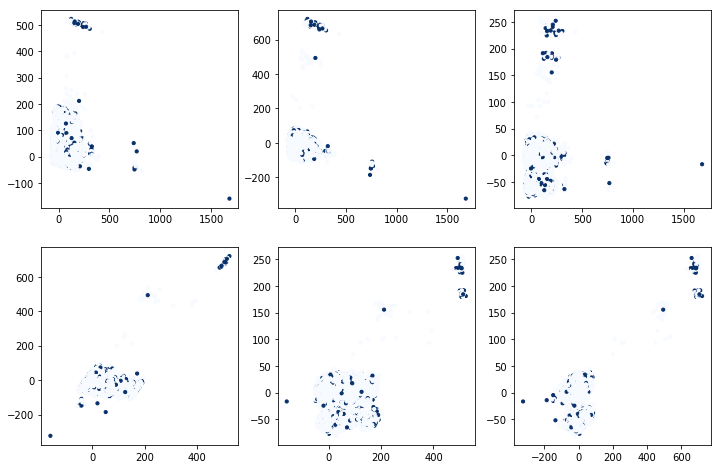

In [20]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 8))
ax1.scatter(Xpca[:, 0], Xpca[:, 1], c=y, cmap=cm.Blues, s=10)
ax2.scatter(Xpca[:, 0], Xpca[:, 2], c=y, cmap=cm.Blues, s=10)
ax3.scatter(Xpca[:, 0], Xpca[:, 3], c=y, cmap=cm.Blues, s=10)
ax4.scatter(Xpca[:, 1], Xpca[:, 2], c=y, cmap=cm.Blues, s=10)
ax5.scatter(Xpca[:, 1], Xpca[:, 3], c=y, cmap=cm.Blues, s=10)
ax6.scatter(Xpca[:, 2], Xpca[:, 3], c=y, cmap=cm.Blues, s=10)

In [21]:
pca.explained_variance_ratio_

array([  2.69778808e-01,   9.33393804e-02,   7.58280900e-02,
         6.35052414e-02,   5.52598467e-02,   5.06270751e-02,
         4.47971369e-02,   4.17832159e-02,   3.65624910e-02,
         3.52757930e-02,   3.28993385e-02,   3.06268845e-02,
         2.64427867e-02,   2.52235699e-02,   2.35142774e-02,
         1.92234617e-02,   1.83057443e-02,   1.76248022e-02,
         1.08626671e-02,   9.11184410e-03,   6.16424744e-03,
         5.14582963e-03,   4.28217678e-03,   9.42660504e-04,
         7.18792507e-04,   5.35601008e-04,   4.37556508e-04,
         3.74949554e-04,   2.61977881e-04,   1.56843453e-04,
         1.25427131e-04,   1.13688594e-04,   7.12559791e-05,
         4.05042685e-05,   1.45496511e-05,   1.14102613e-05,
         8.99229228e-06,   1.08214021e-06,   1.01033666e-27])

<Container object of 39 artists>

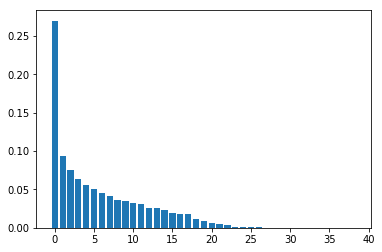

In [22]:
plt.bar(range(Xpca.shape[1]), pca.explained_variance_ratio_)

Gini=0.260+/-0.008, Best=0.267
CPU times: user 6min 17s, sys: 695 ms, total: 6min 18s
Wall time: 53 s


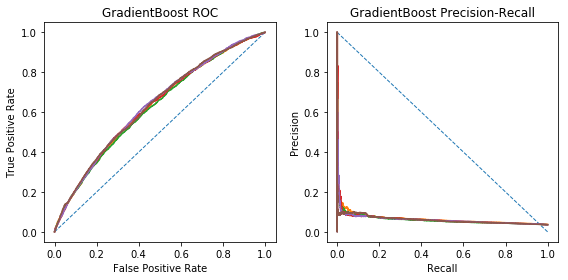

In [23]:
%%time
fig = plt.figure(figsize=(8, 4))
ax21 = fig.add_subplot(1, 2, 1)
ax22 = fig.add_subplot(1, 2, 2)

neutral_line = np.linspace(0, 1, 10)
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

ginis_xgb = []

for i in range(5):

    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(Xpca[:, :20], y, test_size=0.1, random_state=rstate)

    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=8)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

    # GradientBoost
    clf = RandomForestClassifier(n_estimators=200, max_depth=10, n_jobs=8)
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis_xgb.append(my_gini(y_test, y_proba2))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

plt.tight_layout()

print('Gini=%.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))

In [24]:
from sklearn.linear_model import LogisticRegression

Gini=0.249+/-0.010, Best=0.268
CPU times: user 1min 55s, sys: 2.86 s, total: 1min 58s
Wall time: 18.3 s


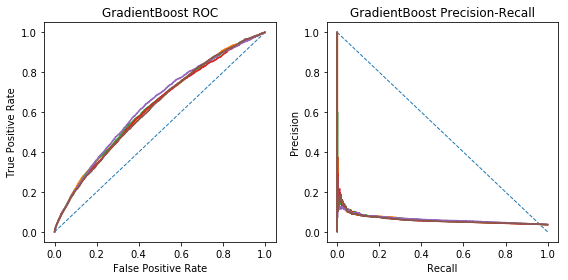

In [25]:
%%time
fig = plt.figure(figsize=(8, 4))
ax21 = fig.add_subplot(1, 2, 1)
ax22 = fig.add_subplot(1, 2, 2)

neutral_line = np.linspace(0, 1, 10)
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

ginis_xgb = []

for i in range(5):

    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(Xpca, y, test_size=0.1, random_state=rstate)

    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=8)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

    # GradientBoost
    clf = LogisticRegression(C=1e4, penalty='l1')
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis_xgb.append(my_gini(y_test, y_proba2))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

plt.tight_layout()

print('Gini=%.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))

Gini=0.239+/-0.012, Best=0.254
CPU times: user 16min 10s, sys: 1.07 s, total: 16min 11s
Wall time: 2min 8s


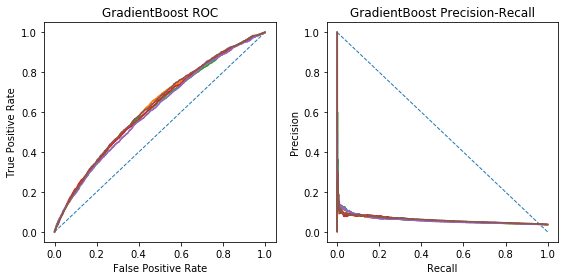

In [26]:
%%time
fig = plt.figure(figsize=(8, 4))
ax21 = fig.add_subplot(1, 2, 1)
ax22 = fig.add_subplot(1, 2, 2)

neutral_line = np.linspace(0, 1, 10)
ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

ginis_xgb = []

for i in range(5):

    rstate = None
    X_train, X_test, y_train, y_test = train_test_split(Xpca, y, test_size=0.1, random_state=rstate)

    num_class1 = np.sum(y_train)
    num_class1_to_resample = 2 * num_class1
    num_class0_to_resample = int(1 * num_class1_to_resample)

    # First, randomly undersample the majority
    rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
    X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

    # Then use SMOTE to oversample the minority
    smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=8)
    X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

    # GradientBoost
    clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=9, learning_rate=0.05, max_delta_step=0,
       max_depth=11, min_child_weight=4, missing=None, n_estimators=200,
       n_jobs=8, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.85)
    clf.fit(X_res, y_res)

    y_pred2 = clf.predict(X_test)
    y_proba2 = clf.predict_proba(X_test)
    ginis_xgb.append(my_gini(y_test, y_proba2))
    report2 = classification_report(y_test, y_pred2, digits=4,
                                   labels=None, target_names=None)

    precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
    ax21.plot(fpr2, tpr2)
    ax21.set_xlabel('False Positive Rate')
    ax21.set_ylabel('True Positive Rate')
    ax21.set_title('GradientBoost ROC')
    ax22.plot(recall2, precision2)
    ax22.set_xlabel('Recall')
    ax22.set_ylabel('Precision')
    ax22.set_title('GradientBoost Precision-Recall')

plt.tight_layout()

print('Gini=%.3f+/-%.3f, Best=%.3f' % (np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))